<a href="https://colab.research.google.com/github/megabebra228/NLP/blob/main/ru_ba_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Формулировка задания

Требуется построить и обучить модель, способную совершать переводы предложений с русского на башкирский язык.

# Описание использованных инструментов

Машинный перевод является типичной Seq2Seq задачей. Одной из самых эффективных моделей решения такого типа задач является Transformer.

Модель состоит из блока энкодера и декодера: в энкодер будут поступать предложения на русском языке, декодер же будет последовательно выдавать токены на башкирском, строя таким образом предложения.

Энкодер включает в себя два основных слоя: Multi-Head Attention, "обогощаяющий" входящие эмбеддинги слов контексной информацией, и Position-Wise Feed-Forwarding, выполняющий нелинейное преобразование эмбеддингов.

Декодер включает в себя Masked Multi-Head Attention - от обычного он отличается лишь тем, что контекстная информация берётся постепенно, по мере строительства последовательности; а также Source-Target Attention - "обогащение" эмбеддингов, подаваемых в декодер, контексной инфорацией из предложения, поступившего в энкодер.

Далее получившийся в декодере эмбеддинг поступает в линейный слой, который проецирует эмбеддинг на вектор с размерностью, равной размеру получившегося Target словаря. После применения Softmax-а получаем набор вероятностей для каждого токена, которая определяет, какой токен из словаря наиболее подходит для того, чтобы продолжить ту последовательность, которая была на дана декодеру на входе.

# Код с объяснениями


## Подготовка датасета

Для тренировки модели (а также ее валидации) требуется размеченный датасет, состоящий из корпуса распараллеленных предложений: одно и то же предложение в башкирском и русском переводах.

Воспользуемся датасетом необходимого формата, взятого из https://github.com/AigizK/bashkort-parallel-corpora.

Из всего разнообразия представленных в репозитории датасетов, возьмём tsv-файл, содержащий в себе перевод нескольких книг с башкирского на русский. Для удобства чтения файла, он был переведен в обычный txt формат. Загрузим его из Google диска:

In [ ]:
import gdown
!gdown 14RyZtkJz0CSK4gIpSpw8cftubGfATo82

Downloading...
From: https://drive.google.com/uc?id=14RyZtkJz0CSK4gIpSpw8cftubGfATo82
To: /content/ba-ru.txt
100% 28.1M/28.1M [00:00<00:00, 45.4MB/s]


После загрузки txt файла из него необходимо изъять предложения на русском и башкирском, а также отфильтровать их: удалить знаки пунктуации и цифры, привести все к нижнему регистру. Знаки пунктуации и цифры лучше удалить, так как это облегчит target словарь, что сделает тренировку чуть быстрее, а результат точнее(для выполнения нашей задачи - перевод небольших предложений с русского на башкирский - знаки препинания и цифры играют второстепенную роль).

In [ ]:
import string
rus_alpha_lower = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
rus_alpha_capital = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'

rus_alpha_lower = [symb for symb in rus_alpha_lower]
rus_alpha_capital = [symb for symb in rus_alpha_capital]

bash_alpha_lower = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяәөүһҙҫҡғ'
bash_alpha_capital = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯӘӨҮҺҘҪҠҒ'

def filter_bash(sent):
  for symb in sent:
    if (symb not in bash_alpha_lower and symb not in bash_alpha_capital) and (symb != ' ' and symb != '\n'):
      sent = sent.replace(symb, '')

  for i in range(len(bash_alpha_capital)):
    sent = sent.replace(bash_alpha_capital[i], bash_alpha_lower[i])
  sent = sent.lstrip(' ')
  sent = sent.rstrip(' ')
  return sent

def filter_rus(sent):
  for symb in sent:
    if (symb not in rus_alpha_lower) and (symb not in rus_alpha_capital) and (symb != ' ') and (symb != '\n'):
      sent = sent.replace(symb, '')

    for i in range(len(rus_alpha_capital)):
      sent = sent.replace(rus_alpha_capital[i], rus_alpha_lower[i])
    sent = sent.lstrip(' ')
    sent = sent.rstrip(' ')
  return sent

Сохраним отфильтрованные предложения нужного формата (предложение на русском - предложение на башкирском) в data.txt

In [ ]:
bash_sent_list = []
rus_sent_list = []
with open('/content/ba-ru.txt') as f:
  for line in f:
    curr_line = line.split('\t')
    if (len(curr_line)) != 3:
      continue

    bash_sent = curr_line[1].rstrip('\n')
    rus_sent = curr_line[2].rstrip('\n')

    bash_sent = filter_bash(bash_sent)
    rus_sent = filter_rus(rus_sent)

    if bash_sent == '' or rus_sent == '':
      continue

    bash_sent_list.append(bash_sent)
    rus_sent_list.append(rus_sent)

f = open('/content/data.txt', 'w+')
for i in range(len(bash_sent_list)):
  if rus_sent_list[i] == '' or bash_sent_list[i] == '':
    continue
  res_line = rus_sent_list[i] + '\t'  + bash_sent_list[i] + '\n'
  f.write(res_line)

f.close()

In [ ]:
with open('/content/data.txt') as f:
  lines = f.readlines()

data_q = len(lines)
print('Количество пар предложений: ', data_q)

Количество пар предложений:  134482


Делим полученный датасет на train_dataset и valid_dataset случайным образом. На количество предложений, которые будут взяты из датасета, влияет параметр NUM_OF_ROWS (в нашем случае берем весь датасет), а на объем train_dataset - параметр WEIGHTS_TRAIN.

Нужно определиться с соотношением тренировочных и валидационных данных. Для этого на уменьшенном датасете была проведена оценка эффективности обучения модели при различных значениях WEIGHTS_TRAIN.

Полученные значения при различных весах представлены на скринах:


При WEIGHTS_TRAIN = 0.7:
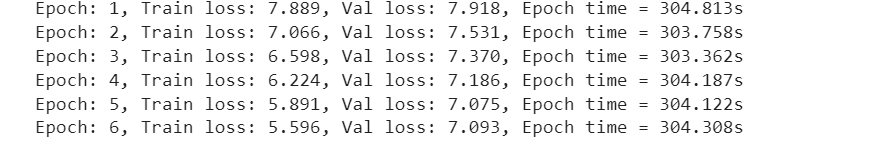

При WEIGHTS_TRAIN = 0.8:
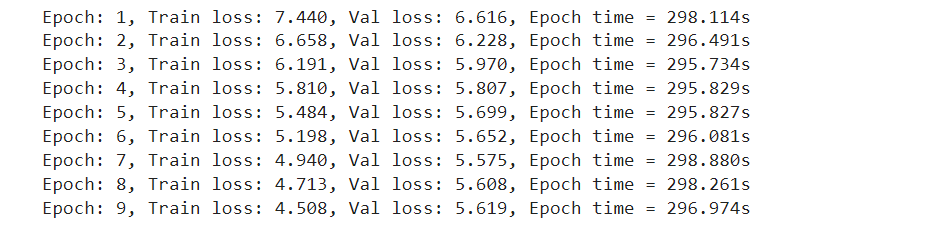

При WEIGHTS_TRAIN = 0.9:
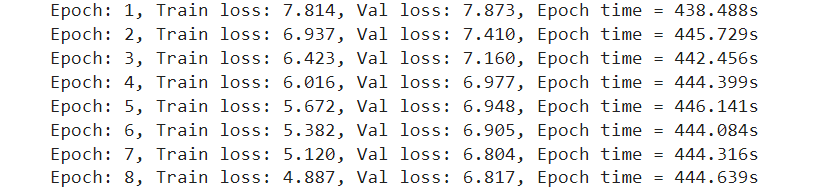

В случае c соотношением 7/3 тренировочных данных к валидационным значение кросс-энтропии для валидационной подборки держится на уровне 7, что говорит о недостаточности объема тренировочного датасета.

В случае с соотношением 9/1 значение держится тоже в районе 7. Это говорит о переобучении модели, либо просто о недостатке объема валидационного датасета для демонстрации корректной эффективности модели.

Наиболее оптимальными результатами обладает соотношение 8/2, его и возьмем. (На первых нескольких эпохах судить об эффективности разметки данных не очень правильно, однако ограничение колаба на использование аппаратного ускорителя вынуждает довольствоваться тем, что есть. Да и весомая разница в результатах явно говорит о том, что 8/2 разметка - оптимальная)

In [ ]:
f_train = open('/content/data_train.txt', 'w+')
f_valid = open('/content/data_valid.txt', 'w+')

import random


import math

NUM_OF_ROWS = data_q
WEIGHTS_TRAIN = 0.8

num_of_train = math.floor(NUM_OF_ROWS * WEIGHTS_TRAIN)

list_of_num = [i for i in range(data_q)]
sample_of_nums = random.sample(list_of_num, NUM_OF_ROWS)
sample_of_train_nums = random.sample(sample_of_nums, num_of_train)

train_sent = []
valid_sent = []

with open('/content/data.txt') as data:
  lines_of_data = data.readlines()

sample_of_nums = set(sample_of_nums)
sample_of_train_nums = set(sample_of_train_nums)
for i in range(data_q):
  if i in sample_of_nums:
    if i in sample_of_train_nums:
      f_train.write(lines_of_data[i])
    else:
      f_valid.write(lines_of_data[i])

f_train.close()
f_valid.close()

Загружаем необходимые библиотеки.

In [ ]:
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Воспользуемся объектами torch.datapipes для хранения пар предложений. Заведем train и valid, которые будут итерироваться через тренировочные и валидационные данные соответственно.

In [ ]:
FILE_PATH = "/content/data_train.txt"
train = dp.iter.IterableWrapper([FILE_PATH])
train = dp.iter.FileOpener(train, mode='rb')
train = train.parse_csv(skip_lines=0, delimiter='\t', as_tuple=True)

In [ ]:
FILE_PATH = "/content/data_valid.txt"
valid = dp.iter.IterableWrapper([FILE_PATH])
valid = dp.iter.FileOpener(valid, mode = 'rb')
valid = valid.parse_csv(skip_lines = 0, delimiter = '\t', as_tuple = True)

In [ ]:
print('Num of pairs in train dataset: ', len(list(train)))
print('Num of pairs in validation dataset: ', len(list(valid)))

Num of pairs in train dataset:  107585
Num of pairs in validation dataset:  26897


Для удобства заведем отдельные функции-токенайзеры для русского и башкирского языков. Оба токенайзера используют nltk.word_tokenize()

In [ ]:
def ru_tokenize(text):
  return word_tokenize(text)

def bash_tokenize(text):
  return word_tokenize(text)

In [ ]:
def getTokens(data_iter, place):
  for russian, bashkir in data_iter:
        if place == 0:
            yield ru_tokenize(russian)
        else:
            yield bash_tokenize(bashkir)

Создадим source и target словари на основе train-а. Из важных гиперпараметров необходимо подобрать MIN_FREQ - необходимая минимальная частота встречаемости слова.

Опять же перебираем значения и смотрим на результаты обучения (опустим случай min_freq = 1, т.к. при датасете такого размера он точно неэффективен):

MIN_FREQ = 2

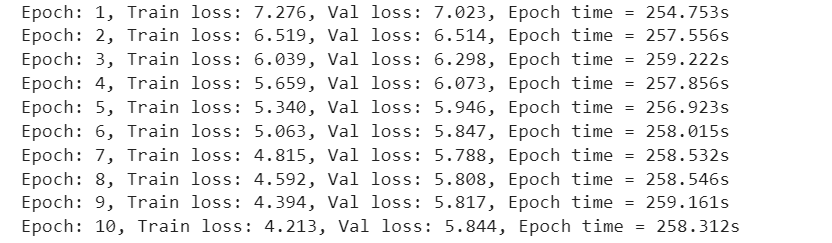

MIN_FREQ = 3
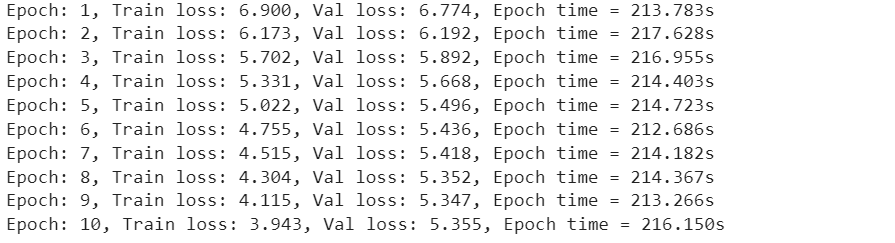

MIN_FREQ = 4
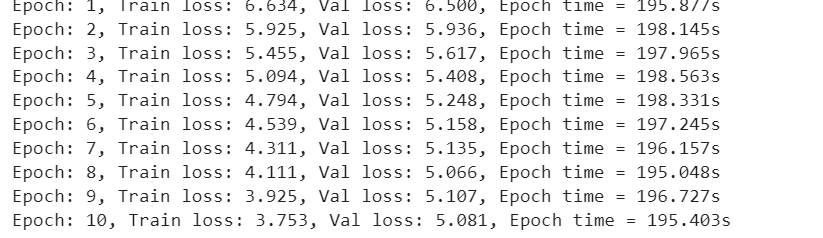

MIN_FREQ = 5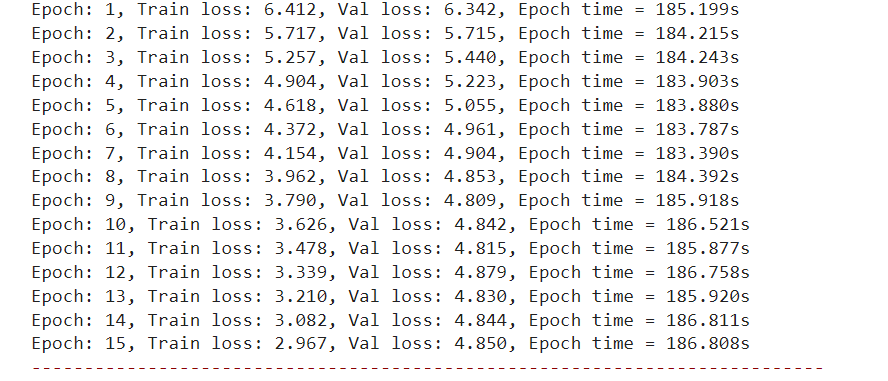

MIN_FREQ = 6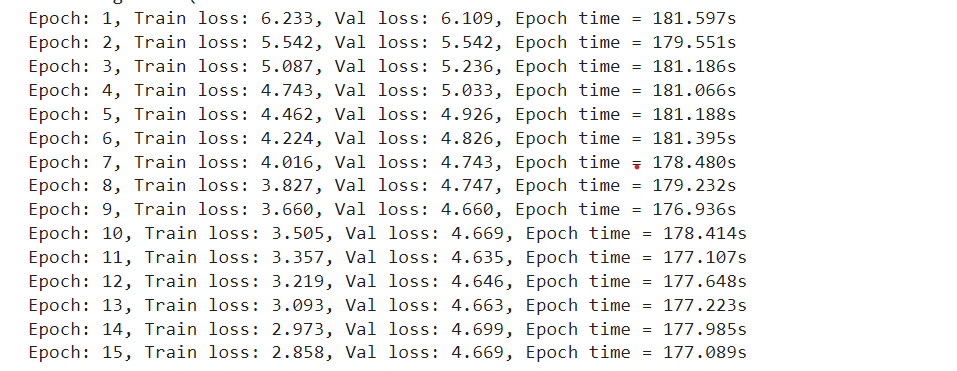

Как мы видим, результаты обучения на одном и том же датасете улучшается вместе с MIN_FREQ. Однако, начиная с MIN_FREQ = 4, некоторые довольно часто встречаемые слова уже начинают теряться из словаря. Так что наиболее оптимальным решением будет выбор MIN_FREQ = 3.

In [ ]:
MIN_FREQ = 3

In [ ]:
source_vocab = build_vocab_from_iterator(
    getTokens(train, 0),
    min_freq=MIN_FREQ,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

In [ ]:
target_vocab = build_vocab_from_iterator(
    getTokens(train,1),
    min_freq=MIN_FREQ,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

In [ ]:
len_src = len(source_vocab.get_itos())
len_tgt = len(target_vocab.get_itos())

print('Source vocab volume: ',len_src)
print('Target vocab volume ',len_tgt)

Source vocab volume:  31053
Target vocab volume  27913


В соответствии с порядком в параметре specials при построении словарей, сохраняем индексы меток unk, pad, sos и eos в отдельных переменных

In [ ]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 3, 0, 1, 2

Для удобства заводим мапу vocab_transform и сохраняем в ней оба словаря. Далее в каждом словаре ставим индекс UNK_IDX за дефолтный.

In [ ]:
vocab_transform = {}
SRC_LANGUAGE = 'ru'
TGT_LANGUAGE = 'bash'

vocab_transform[SRC_LANGUAGE] = source_vocab
vocab_transform[TGT_LANGUAGE] = target_vocab

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Непосредственно модель

Сначала создадим класс Positional Encoding, принимающий в качестве параметра размерность эмбеддинга и генерирующий эмбеддинг, указывающий на позицию слова в предложении, которые впоследствии складывается с эмбеддингом этого слова.

Также создадим класс TokenEmbedding, который, используя готовый класс nn.Embedding, будет конвертировать поступающие предложения в набор эмбеддингов.

Теперь объявим непосредственно класс Seq2SeqTransformer, в основе своей использующий класс nn.Transformer из библиотеки torch.

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Как мы видели, в энкодере и декодере Трансформера использовались паддинговые маски для src и tgt, а также специальная square_subsequent_mask, использующаяся для Masked Multi-Head Attention входных данных в декодере. Ниже мы расписываем функции, генерирующие эти маски:

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Устаналиваем значения гиперпараметров модели. Для размерности эмбеддингов, количества голов в Multi-Head Attention и количества слоев для энкордера и декодера используем наиболее часто используемые значения. Для EMB_SIZE это 512, 768, 1024..., однако в виду ограниченности памяти единственный подходящий оптимальный вариант это EMB_SIZE = 512. Отсюда выводится и оптимальное значение для NHEAD-а. Так как объем тренировачного датасета небольшой (и время работы с аппаратным ускорителем ограничено) будем использовать только три слоя энкодеров и декодеров.

Размер батча мы возьмём 64, так как требуется минимизировать время тренировки модели из-за ограничений. По хорошему для датасета такого размера лучше брать BATCH_SIZE = 32.

FFN_HID_DIM - это размерность вектора, в который "расширяется" эмбеддинг токена, входящий в слой Feed-Forward. Обычно его расширяют в 2-4 раза, чтобы потерять как можно меньше информации с каждой позиции после нелинейного преобразования эмбеддинга.

В нашем случае эмпирически проверено, что увеличение размерности FFN ведет к ухудшению результатов, поэтому берем FFN_HID_DIM = EMB_SIZE.

DROPOUT влияет на вероятность выкидвания некоторых весов из нейронной сети в ходе обучения модели. Для трансформеров обычно ставится DROPOUT = 0.1, однако из-за относительно небольшого датасета с целью избежания переобучения лучше подойдет увеличенный DROPOUT = 0.3.

In [ ]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.3

Создаем объект класса модели с определенными параметрами.

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

Напишем класс на основе _LRScheduler, которы будет изменять Learning Rate оптимайзера в соотвествии с формулой, представленной в статье "Attention Is All You Need".

Learning Rate будет линейно увеличиваться в зависимости от параметра WARMUP_STEPS, а потом резко уменьшаться.

Для эмбеддингов размерности 512 рекомендуют брать WARMUP_STEPS = 4000.

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler

WARMUP_STEPS = 4000

optimizer = torch.optim.Adam(transformer.parameters(), lr= 0.0001, betas=(0.9, 0.98), eps=1e-9)

class Scheduler(_LRScheduler):
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups


def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

Создадим класс, который будет считать кросс-энтропию полученных предсказаний.

Мы также будем использовать label smoothing, который делает желаемый результат не таким строгим, тем самым смягчая требования для модели во время её тренировки. Его также рекомендуют использовать, так что возьмем стандартное значение LABEL_SMOOTHING = 0.1

In [ ]:
LABEL_SMOOTHING = 0.1

class TranslationLoss(nn.Module):
    def __init__(self, label_smoothing: float=0.0) -> None:
        super().__init__()
        self.loss_func = nn.CrossEntropyLoss(ignore_index    = PAD_IDX,
                                             label_smoothing = label_smoothing)

    def forward(self, logits: Tensor, labels: Tensor) -> Tensor:
        vocab_size = logits.shape[-1]
        logits = logits.reshape(-1, vocab_size)
        labels = labels.reshape(-1).long()
        return self.loss_func(logits, labels)

Напишем функцию sequential_transforms, которая преобразует входящее предложение в тензор. Она будет состоять из функции-токенизатора; функции, переводящей получившийся массив токенов в массив индексов словаря; функции, добавляющей в начало и конец индексы тегов BOS и EOS соотвественно.

В функции collate_fn мы преобразуем батч входящих предложений в тензор с помощью написанной sequential_transforms и добавляем в конец предложений индексы паддингов для уравнивания размеров всех предложений в текущем батче.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: list[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
token_transform = {}

token_transform[SRC_LANGUAGE] = ru_tokenize
token_transform[TGT_LANGUAGE] = bash_tokenize

text_transform = {}

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:

    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Здесь мы расписываем функции, необходимые для тренировки и валидации модели. Для каждой функции мы создаем DataLoader, подгружающий предложения из тренировочного или валидационного датасета, разбивающий их на батчи и преобразовывающий их в тензоры. В каждой функции мы считаем logits, т.е. предсказания следующего токена, и считаем loss, т.е. ошибочность этого предсказания.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
def train_epoch(model: nn.Module,
                loader: DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler):
    model.train()


    losses = 0

    for src, tgt in loader:
        tgt = tgt.type(torch.LongTensor)
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        curr_loss = loss_fn(logits, tgt_out)
        losses += curr_loss.item()

        optimizer.zero_grad()
        curr_loss.backward()
        optimizer.step()

        if scheduler is not None:
          scheduler.step()

    return losses / len(list(loader))

def evaluate(model : nn.Module,
             loss_fn: torch.nn.Module,
             loader: DataLoader):
    model.eval()
    losses = 0

    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits, tgt_out)
            losses += loss.item()

    return losses / len(list(loader))

Очищаем кеш видеокарты для освобождения памяти и Garbage Collector (на всякий случай).

In [ ]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

Здесь мы непосредственно запускаем тренировку модели, параллельно считая evaluation для оценки эффективности обучения на каждой эпохе.

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 7.678, Val loss: 7.068, Epoch time = 206.047s
Epoch: 2, Train loss: 7.173, Val loss: 6.838, Epoch time = 204.390s
Epoch: 3, Train loss: 6.961, Val loss: 6.699, Epoch time = 204.264s
Epoch: 4, Train loss: 6.802, Val loss: 6.510, Epoch time = 204.244s
Epoch: 5, Train loss: 6.681, Val loss: 6.473, Epoch time = 204.326s
Epoch: 6, Train loss: 6.584, Val loss: 6.324, Epoch time = 216.926s
Epoch: 7, Train loss: 6.495, Val loss: 6.232, Epoch time = 222.649s
Epoch: 8, Train loss: 6.411, Val loss: 6.142, Epoch time = 206.439s
Epoch: 9, Train loss: 6.336, Val loss: 6.077, Epoch time = 204.667s
Epoch: 10, Train loss: 6.268, Val loss: 5.970, Epoch time = 202.460s
Epoch: 11, Train loss: 6.203, Val loss: 5.992, Epoch time = 202.135s
Epoch: 12, Train loss: 6.145, Val loss: 5.919, Epoch time = 201.079s
Epoch: 13, Train loss: 6.084, Val loss: 5.887, Epoch time = 199.907s
Epoch: 14, Train loss: 6.032, Val loss: 5.927, Epoch time = 199.565s
Epoch: 15, Train loss: 5.983, Val loss: 5.9

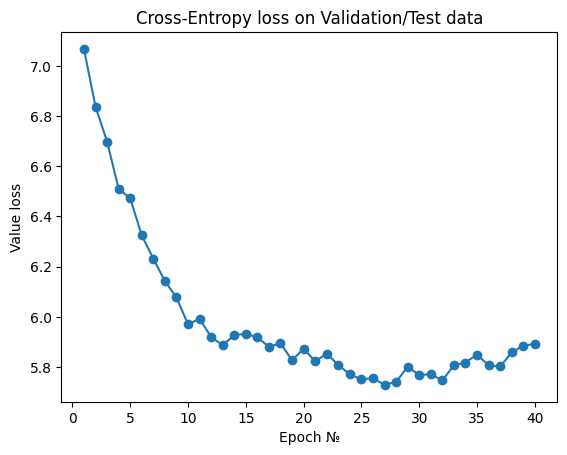

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 35

list_of_val_loss = []
list_of_epochs = [i for i in range(1, NUM_EPOCHS + 1)]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_loader, TranslationLoss(LABEL_SMOOTHING),optimizer, Scheduler(optimizer, EMB_SIZE, WARMUP_STEPS) )
    end_time = timer()
    val_loss = evaluate(transformer, TranslationLoss(), valid_loader)
    list_of_val_loss.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


import matplotlib.pyplot as plt

plt.title('Cross-Entropy loss on Validation/Test data')
plt.xlabel('Epoch №')
plt.ylabel('Value loss')

plt.plot(list_of_epochs, list_of_val_loss, '-o')
plt.show()

Как видно по графику, модель стабильно обучалась до ~25 эпохи, потом пошел процесс переобучения.

##Перевод


Теперь модель готова для использования. Для получения выходной последовательности будем использовать жадный алгоритм: в начале кидаем в декодер тег BOS, далее на каждом шаге считаем logits, берем токен из словаря с наибольшими очками (вероятностью), добаляем его к входной последовательности. Процесс будет идти, пока наиболее вероятным токеном не будет тег EOS (конец предложения).

Можно было бы использовать более эффективные алгоритмы, например beam_search, однако размер TGT словаря небольшой и переводить мы будем небольшие простые предложения, так что жадный алгоритм будет работать довольно эффективно.

In [ ]:
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import torch


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<sos>", "").replace("<eos>", "")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Примеры переводов

Посмотрим, как модель переводит простые предложения с распространенными словами:

In [ ]:
def translate_list(list_of_str : list):
  for word in list_of_str:
      translated = translate(transformer, word)
      print(word + ', ' + translated)

Посмотрим, насколько хорошо переводит существительные. Возьмем несколько произвольных (довольно часто употребляемых) слов.

In [ ]:
list_of_str = ['кот', 'дерево', 'мальчик', 'девочка', 'человек', 'лошадь']

translate_list(list_of_str)

кот,  бесәй 
дерево,  ағас 
мальчик,  малай 
девочка,  ҡыҙыҡай 
человек,  кеше 
лошадь,  ат 


Все слова были переведены безупречно. Это связано с тем, что существительные в именном падеже довольно часто употреблялись в датасете в простых предложениях с простой конструкцией "подлежащее - сказуемое", поэтому в source-target attention-е эти слова получали более явную зависимость от своих переводов.



Посмотрим, как модель переводит различные склонения глаголов:

In [ ]:
list_of_str = ['думать', 'думает', 'думают', 'они долго думают']
translate_list(list_of_str)

думать,  уйларға кәрәк 
думает,  уйлай 
думают,  нимә һөйләйһе 
они долго думают,  улар оҙаҡ <unk> 


Слово "думать" было переведено как "надо думать". Это связано с тем, что слово "думать" часто употребляется вместе с каким-то глаголом ("надо думать", "давайте думать"), поэтому модель дополняет это слово еще одним - "кәрәк".

Слово "думает" модель переводит правильно. Скорее всего, из-за того, что это слово "независимее" от других слов, нежели чем слово "думать", и поэтому оно получает более явную корреляцию со словом "уйлай" в source-target attention-е.

Интересный момент получается со словом "думают". Перевод слова "думают" - "уйлалар". Его нет в target-словаре, однако при вводе этого слова получается совершенно несвязанное с ним словосочетание. Однако при добавлении контекста - "они долго думают", модель правильно переводят "они долго", а потом заменяет "думают" тегом "unk". Скорее всего это связано с использованным жадным алгоритмом при построении последовательности. Если бы использовался beam search, то скорее всего "думают" заслуженно получил бы тег "unk" в переводе.

Еще один пример важности контекста при переводе уже со словом "поет":

In [ ]:
list_of_str = ['поет', 'петь', 'девочка поет', 'девочка красиво поет']
translate_list(list_of_str)

поет,  йәнлектәр ҙә йырлай 
петь,  <unk> 
девочка поет,  ҡыҙыҡай йырлай 
девочка красиво поет,  ҡыҙыҡай матур йырлай 


Одного слова "поет" недостаточно, чтобы составить нормальную корреляцию с переводом "йырлай", однако в предложении "девочка поет" и "девочка красиво поет" эмбеддинг "насыщается" контекстом, и получается составить правильный перевод.

Рассмотрим последний интересный пример:

In [ ]:
list_of_str = ['он делает дело очень хорошо']
translate_list(list_of_str)

он делает дело очень хорошо,  ул бик яҡшы эшләй 


"ул бик яҡшы эшләй" дословно переводится как "он очень хорошо работает", т.е. перевод получился хороший, но не дословный. Это связано с особенностями датасета, который состоит из художественного перевода башкирских произведений.

# Выводы

Несмотря на не очень хорошие показатели по валидационным данным итоговой модели, она способна переводить короткие предложения, или хотя бы приблизительно передавать их смысл в своем переводе.

Модель можно было бы улучшить, подобрав более подходящие гиперпараметры, однако из-за ограничений в колабе сделать это весьма проблематично.

Но ключевую роль в результативности модели играет качество датасета и синтаксическая схожесть языков. Если бы датасет представлял бы из себя набор коротких предложений с дословным переводом, то модель справлялась бы со своей задачей гораздо лучше. Синтаксическая языковая схожесть позволяет модели выводить более корректные зависимости между эмбеддингами токенов на разных языках в source-target attention-е, что тоже сильно способствует увеличению качества модели. Башкирский и русский языки, хотя и имеют некоторые полезные сходства, например общие склонения по падежам, имеют различные синтаксические структуры в предложениях. Например, в башкирском языке глаголы ставятся в конец предложения, в русском языке же такого правила нет. Это делает обучение сложнее, так как эмбеддинги хранят в себе свою позицию в предложении, благодаря Positional Encoding.

Для сравнения, модель transformer с примерно такими же гиперпараметрами, пользуясь датасетом multi30k, представляющий из себя корпус распараллеленных предложений на английском и немецком языках и состоящий из 30к предложений, за 18-19 эпох достигает кросс-энтропии размера ~2 на валидационных данных. На это влияет как датасет, специально спроектированный для решения задачи машинного перевода, так и родство английского и немецкого языков.



# Использованные источники
https://pytorch.org/tutorials/beginner/translation_transformer.html - статья по использованию трансформеров для решения задачи машинного перевода

https://pytorch.org/data/main/torchdata.datapipes.iter.html - статья по data pipes

https://kikaben.com/transformers-training-details/ - статья с рекомендациями по тренировке трансформеров